In [0]:
import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError ('GPU device not found')
#   print('Found GPU at: {}' .format(device_name))

In [0]:
!pip install -q keras
import keras

In [36]:
from google.colab import files
uploaded = files.upload()

Saving housing.csv to housing (1).csv


In [0]:
import numpy
import pandas

from keras import models
from keras import layers
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Dropout,regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras import initializers
from keras import optimizers

In [0]:
# load dataset
dataframe = pandas.read_csv("housing.csv", delim_whitespace=True, header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:13]
Y = dataset[:,13]

In [7]:
from keras import initializers
from keras import optimizers

def baseline_model():
    model = Sequential()
    model.add(layers.Dense(13, input_shape=(13,), activation='relu'))
    model.add(layers.Dense(1))    
    model.compile(optimizer=optimizers.adam(), loss='mse',  metrics=['mae'])
    return model
  
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -42.64 (23.28) MSE


## Step 3: Modeling The Standardized Dataset

In [28]:
# evaluate model with standardized dataset
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -34.48 (35.62) MSE


In [20]:
from keras import initializers
from keras import optimizers


def baseline_model():
    model = Sequential()
    model.add(layers.Dense(13, input_dim=13, kernel_initializer=initializers.random_normal(), activation='relu'))
    model.add(layers.Dense(1, activation='relu'))    
    model.compile(loss='mse', optimizer=optimizers.adam(), metrics=['mae'])
    return model
  
  
# evaluate model with standardized dataset
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -35.49 (40.05) MSE


## Step 4. Tune The Neural Network Topology

 ### Step 4.1. Evaluate a Deeper Network Topology

In [0]:
def larger_model():
    model = Sequential()
    model.add(layers.Dense(13, input_dim=13, kernel_initializer=initializers.random_normal(), activation='relu'))
    model.add(layers.Dense(6, activation='relu'))    
    model.add(layers.Dense(1))    
    model.compile(loss='mse', optimizer=optimizers.adam(), metrics=['mae'])
    return model
  
# fix random seed for reproducibility
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Larger: -23.40 (25.46) MSE


### Step 4.2. Evaluate a Wider Network Topology

In [39]:
def wider_model():
    model = Sequential()
    model.add(layers.Dense(20, input_dim=13, activation='relu'))
    model.add(layers.Dense(1))    
    model.compile(loss='mse', optimizer=optimizers.rmsprop(), metrics=['mae'])
    return model
  
# fix random seed for reproducibility
numpy.random.seed(seed)
estimators = []

estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Wider: -21.12 (22.35) MSE


## Step 5. Really Scaling up: developing a model that overfits
To figure out how big a model you’ll need, you must develop a model that overfits. This is fairly easy:

* Add layers.
*  Make the layers bigger.
*  Train for more epochs.

In [13]:
from keras import initializers
from keras import optimizers
def overfit_model():
    model = Sequential()
    model.add(layers.Dense(20, input_dim=13, activation='relu'))
    model.add(layers.Dense(13, activation='relu'))
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dense(1))    
    model.compile(loss='mse', optimizer=optimizers.rmsprop(), metrics=['mae'])
    return model

  
val_loss = []
train_loss = []
mean_absolute_error=[]
val_mean_absolute_error = []
num_of_epochs = 200

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

kfold = KFold(n_splits=10, random_state=seed)

for train_index, test_index in kfold.split(X,Y):
  model = overfit_model()
  history=model.fit(X[train_index],Y[train_index],epochs=num_of_epochs,batch_size=5,verbose=0,validation_data=(X[test_index],Y[test_index]))
  
  val_loss.append(history.history['val_loss'])
  train_loss.append(history.history['loss'])
  mean_absolute_error.append(history.history['mean_absolute_error'])
  val_mean_absolute_error.append(history.history['val_mean_absolute_error'])

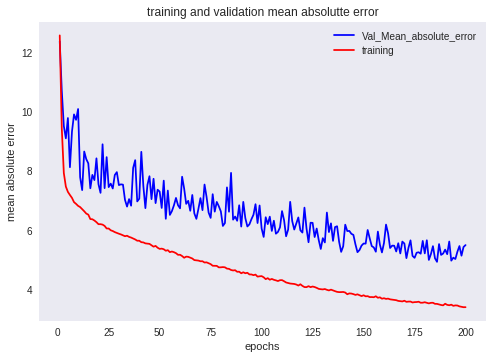

In [32]:
import matplotlib.pyplot as plt

epochs = range(1,num_of_epochs+1)
plt.plot(epochs, numpy.mean(val_mean_absolute_error, axis=0), 'b', label = 'Val_Mean_absolute_error')
plt.plot(epochs, numpy.mean(mean_absolute_error, axis=0), 'r-', label='training')
plt.title('training and validation mean absolutte error')
plt.xlabel('epochs')
plt.ylabel('mean absolute error')
plt.legend()
plt.grid()
plt.show()

## Step 6. Tuning the Model

In [50]:
def overfit_model():
    model = Sequential()
    model.add(layers.Dense(13, input_dim=13, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(layers.Dense(6, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(layers.Dense(1))    
    model.compile(loss='mse', optimizer=optimizers.adam(), metrics=['mae'])
    return model
  
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=overfit_model, epochs=150, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -38.50 (23.96) MSE


## Step 7. Rewriting the code using the Keras Functional API

In [0]:
from keras.layers import Input, Dense
from keras.models import Model

def functional_api():
  # This returns a tensor
  inputs = Input(shape=(13,))
  # a layer instance is callable on a tensor, and returns a tensor
  x = Dense(13, activation='relu')(inputs)
  predictions = Dense(1)(x)

  # This creates a model that includes
  # the Input layer and three Dense layers
  model = Model(inputs=inputs, outputs=predictions)
  model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
  return model


numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=functional_api, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("functional api model with 100 epoch: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

      functional api with 100 epochs: -25.90 (36.30) MSE

## Step 8. Rewriting the code by doing Model Subclassing 

In [51]:
import keras
from keras import layers
import tensorflow as tf
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel,self).__init__()
    self.dense1=tf.keras.layers.Dense(13,activation="relu")
    self.dense1=tf.keras.layers.Dense(6,activation="relu")
    self.dense2=tf.keras.layers.Dense(1)
  
  def call(self,inputs):
    x=self.dense1(inputs)
    return self.dense2(x)

model=MyModel()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X,Y,epochs=4,batch_size=5)

Epoch 1/4
506/506 [==============================] - 7s 13ms/step - loss: 363.1859 - acc: 0.0000e+00
Epoch 2/4
506/506 [==============================] - 1s 1ms/step - loss: 363.1859 - acc: 0.0000e+00
Epoch 3/4
506/506 [==============================] - 1s 1ms/step - loss: 363.1859 - acc: 0.0000e+00
Epoch 4/4
506/506 [==============================] - 1s 1ms/step - loss: 363.1859 - acc: 0.0000e+00


## Step 9. Rewriting the code without using scikit-learn 

In [0]:
def keras_model():
  model = models.Sequential()
  model.add(layers.Dense(13, activation='relu', input_shape=(13,)))
  model.add(layers.Dense(1))
  
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  return model

In [0]:
# Shuffle the dataset before split in values and labels
numpy.random.shuffle(dataset) 
X = dataset[:,0:13]
Y = dataset[:,13]


# K-Fold
k = 10
num_val_samples = len(dataset) // k
val_mae_list = [] # used for validation absolute error
val_mse_list = [] # used for Validation data mean square error

for fold in range(k):
    
    # Validation dataset
    val_data = X[fold * num_val_samples : (fold + 1) * num_val_samples]
    
    # Validation labels corresponding to the validation dataset
    val_label = Y[fold * num_val_samples : (fold + 1) * num_val_samples]
    
    
    # Training Dataset
    partial_train_data = numpy.concatenate([X[:fold * num_val_samples],
                                            X[(fold + 1) * num_val_samples:]],
                                           axis=0)
    
    # Training labels corresponding to the training dataset
    partial_train_label = numpy.concatenate([Y[:fold * num_val_samples],
                                             Y[(fold + 1) * num_val_samples:]],
                                            axis=0)
    
    model = keras_model()
    result = model.fit(partial_train_data, partial_train_label, epochs=200, batch_size=5, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_label, verbose=0)
    val_mse_list.append(val_loss)
    val_mae_list.append(val_mae)

In [44]:
numpy.mean(val_mae_list)

3.669976832389831